## Initialization

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1.0/255)
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    x_col='file_name',
    y_col='real_age',
    seed=12345)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_datagen_flow)
features.shape

(32, 224, 224, 3)

In [4]:
target

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32, 14, 23, 37, 62, 21, 58, 43,
       32, 25, 94, 30, 16, 23, 18, 41, 24, 26, 14, 36, 28, 78, 13])

## EDA

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


<AxesSubplot:>

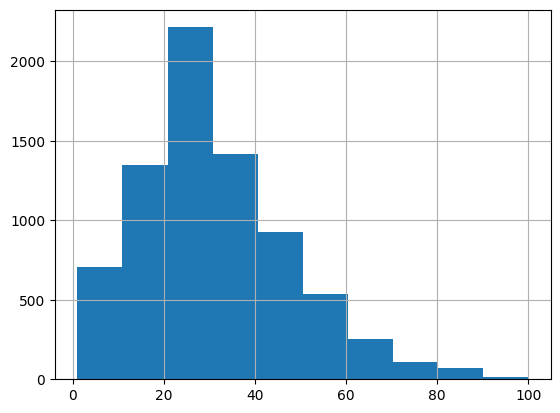

In [7]:
labels['real_age'].hist()

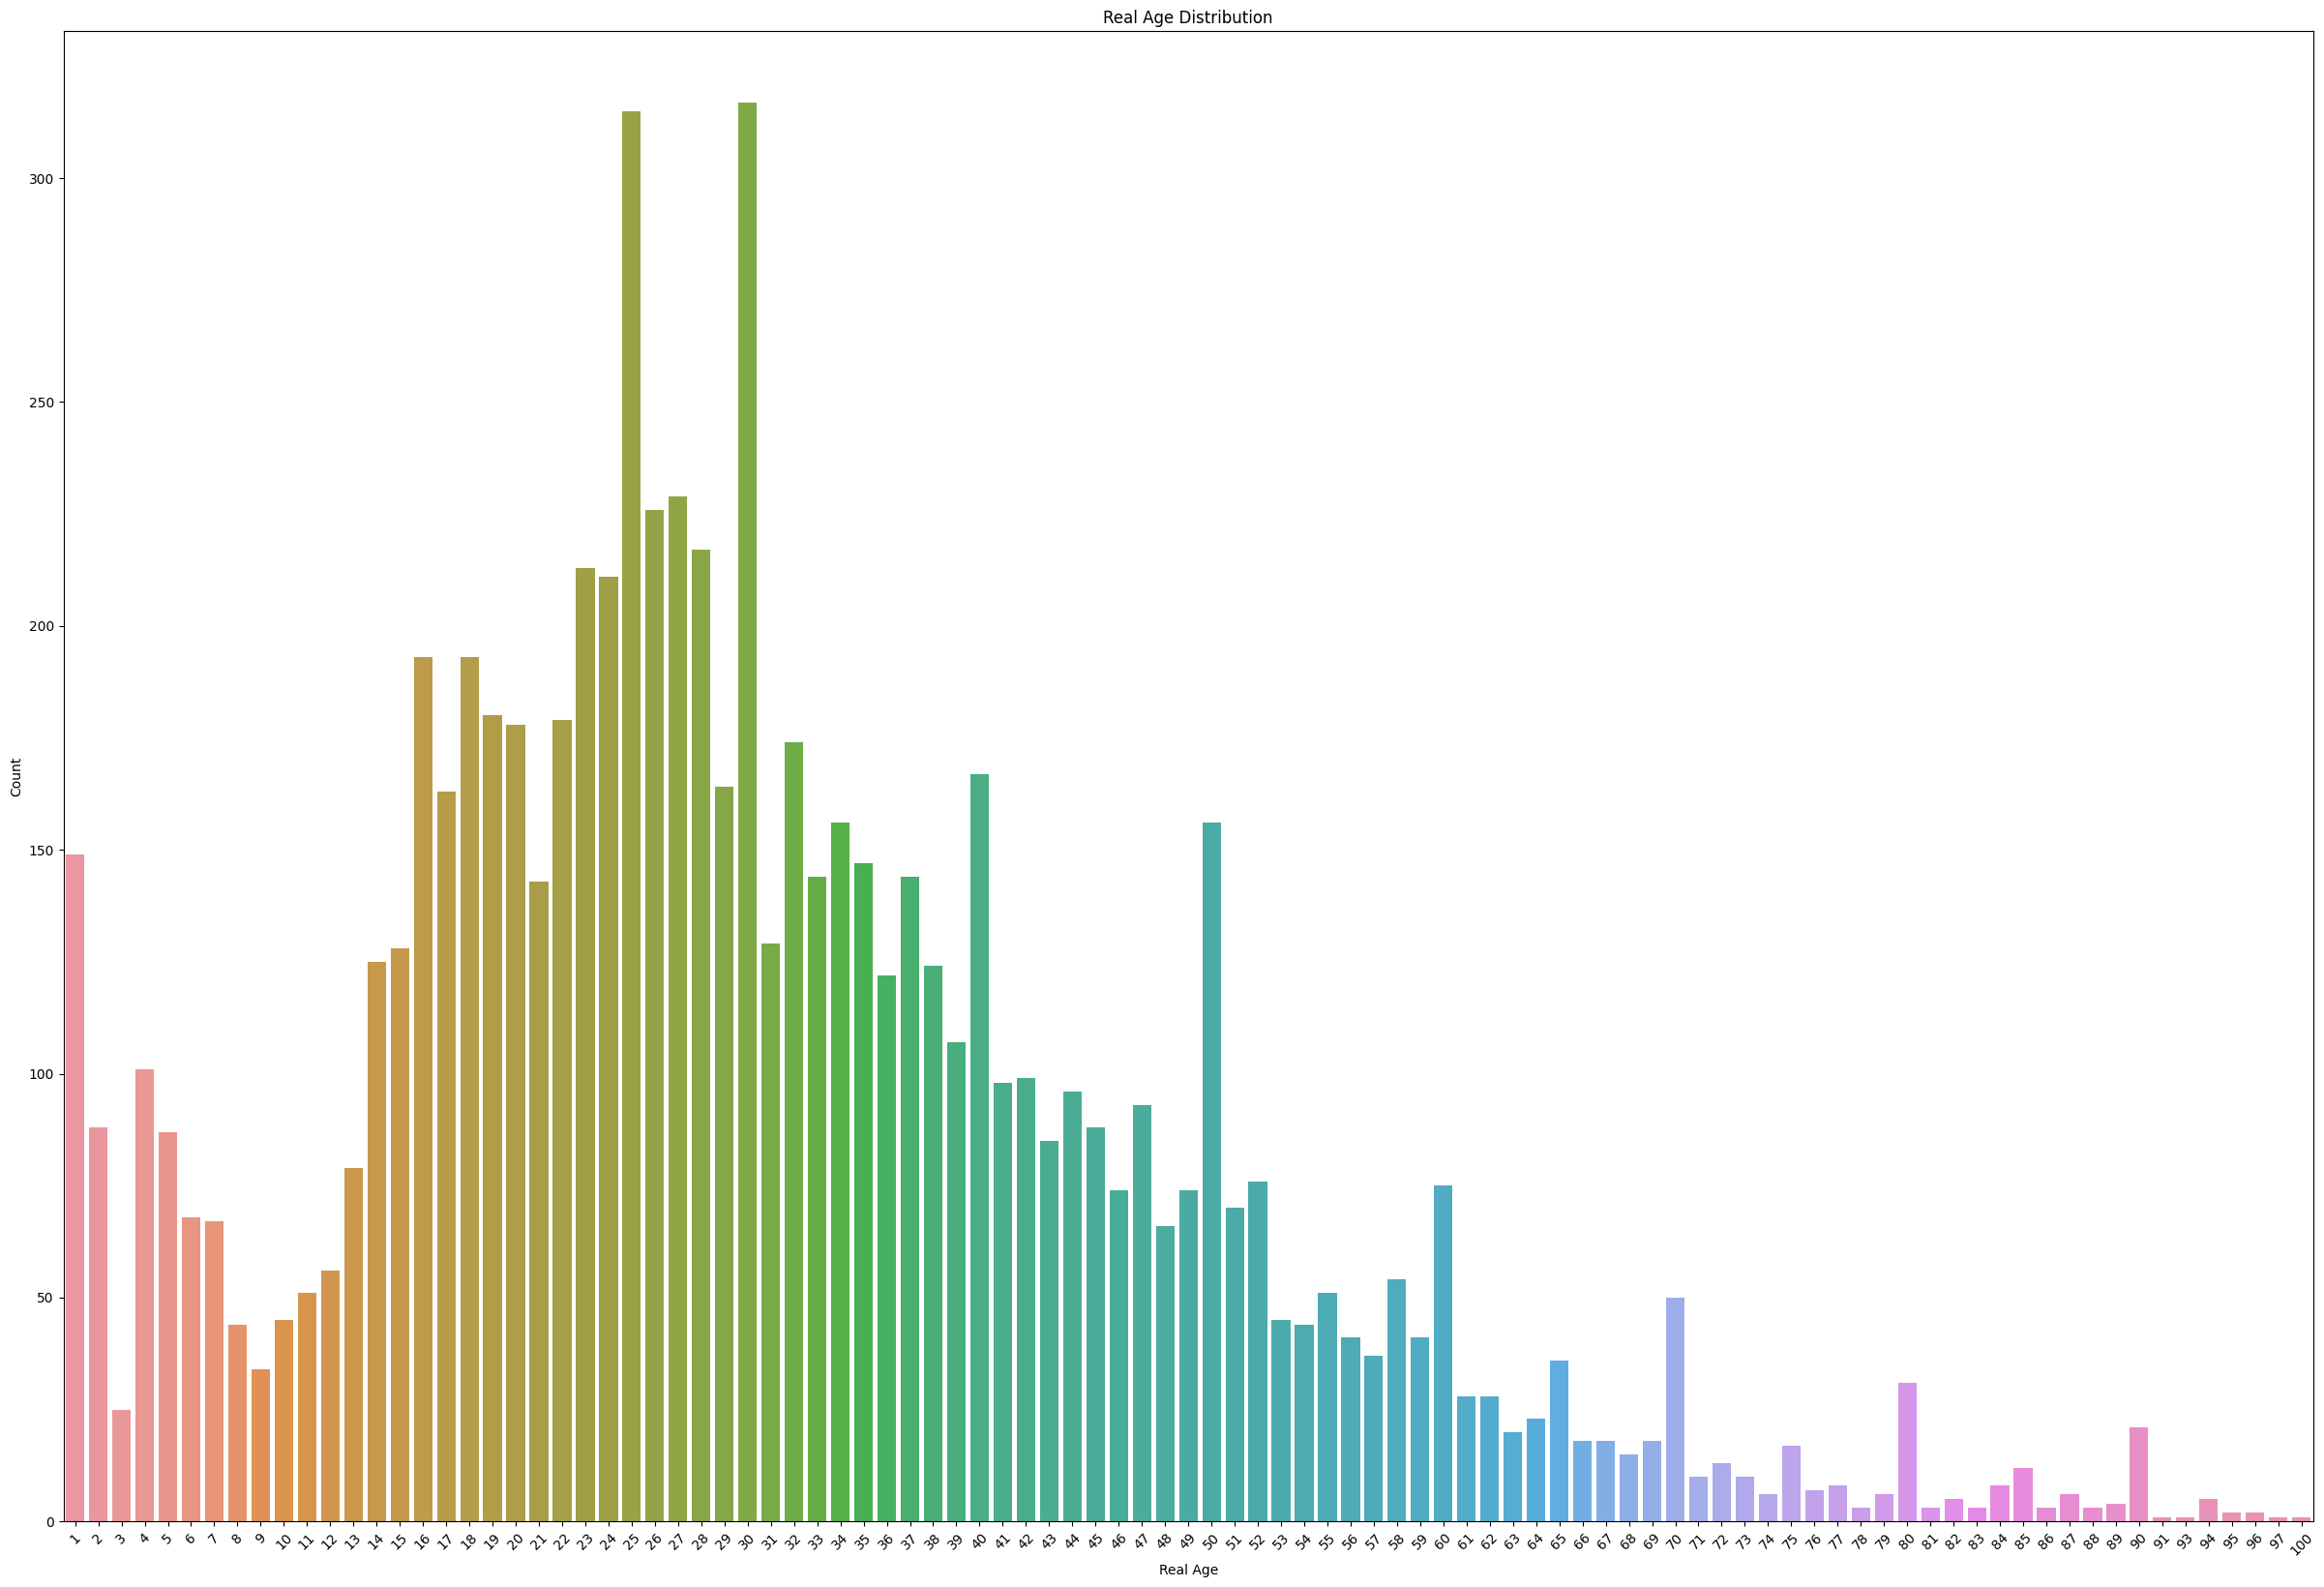

In [8]:
plt.figure(figsize=(30,20))

# Create a bar plot using Seaborn
sns.countplot(x='real_age', data=labels)

# Add labels and title
plt.xlabel('Real Age')
plt.ylabel('Count')
plt.title('Real Age Distribution')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the chart
plt.show()

In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


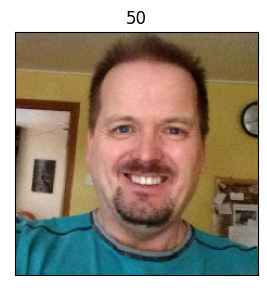

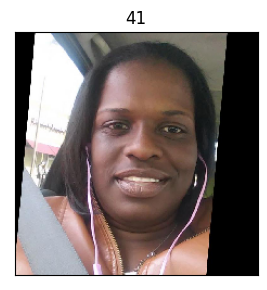

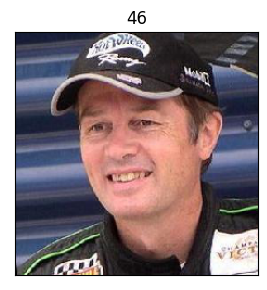

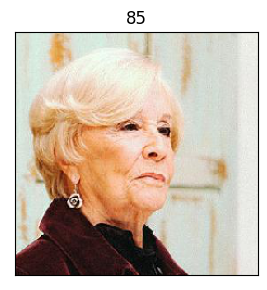

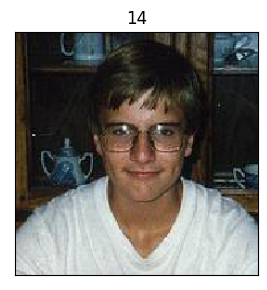

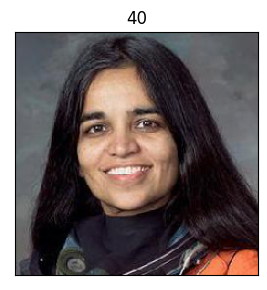

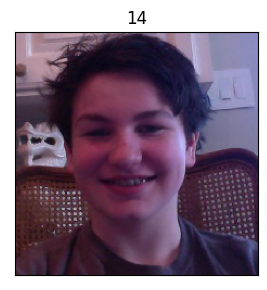

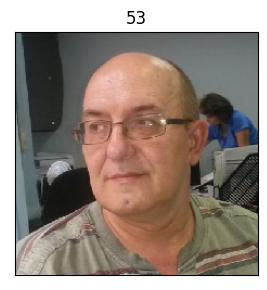

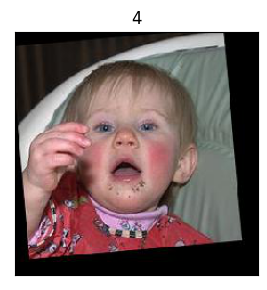

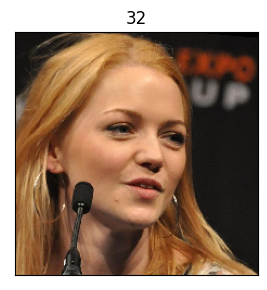

In [10]:
for pic, age in zip(features[:10], target[:10]):
    plt.figure(figsize=(3,3))
    plt.title(age)
    plt.imshow(pic)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

From our explorative data analysis we have discovered the following:
- Mean: 31 years old
- Median: 29 years old
- Age Range: 1 - 100
- Distribution: Left-Skewed
The model may have more trouble determing the age of senior citizens due to the lack of senior aged data samples compared to the availability of other age samples. Some images do have some transformation changes which is good for the model to give in variant augmentations to train and validate with.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Nice initial review!
</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
def load_train(path):
    data = pd.read_csv(path)
    train_datagen = ImageDataGenerator(validation_split=0.25,rescale=1/255,horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(dataframe=data,
                                             directory='/content/drive/MyDrive/cpu_vision_sprint_15/datasets/faces/final_files',
                                             x_col ='file_name',
                                             y_col ='real_age',
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='raw',
                                             subset='training',
                                             seed=300)
    return train_data

In [14]:
def load_test(path):
    data_test = pd.read_csv(path)
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(dataframe=data_test,
                                            directory='/content/drive/MyDrive/cpu_vision_sprint_15/datasets/faces/final_files',
                                            x_col ='file_name',
                                            y_col ='real_age',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='raw',
                                            subset='validation',
                                            seed=300)
    return test_data

In [17]:
def create_model(input_shape):
    
    model = Sequential()
    
    model.add(ResNet50(input_shape=input_shape, weights='imagenet', include_top=False))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                  loss='mse', metrics=['mae']
                  )

    return model

In [18]:
def train_model(model, train_data, test_data, batch_size=32, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )

    return model

In [20]:
train_data = load_train('/content/drive/MyDrive/cpu_vision_sprint_15/datasets/faces/labels.csv')
test_data = load_test('/content/drive/MyDrive/cpu_vision_sprint_15/datasets/faces/labels.csv')
steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = test_data.samples // test_data.batch_size
model = create_model(input_shape=(224, 224, 3))
trained_model = train_model(model,train_data,test_data,epochs=20, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
print('finshed')

Scanning files .
  adding: datasets/faces/ (stored 0%)
  adding: datasets/faces/final_files/ (stored 0%)
  adding: datasets/faces/final_files/006902.jpg (deflated 2%)
  adding: datasets/faces/final_files/003356.jpg (deflated 2%)
  adding: datasets/faces/final_files/002627.jpg (deflated 3%)
  adding: datasets/faces/final_files/004085.jpg (deflated 6%)
  adding: datasets/faces/final_files/005138.jpg (deflated 16%)
  adding: datasets/faces/final_files/004409.jpg (deflated 6%)
  adding: datasets/faces/final_files/000845.jpg (deflated 20%)
  adding: datasets/faces/final_files/001574.jpg (deflated 6%)
  adding: datasets/faces/final_files/003518.jpg (deflated 3%)
  adding: datasets/faces/final_files/004247.jpg (deflated 2%)
  adding: datasets/faces/final_files/000683.jpg (deflated 1%)
  adding: datasets/faces/final_files/006029.jpg (deflated 21%)
  adding: datasets/faces/final_files/002465.jpg (deflated 1%)
  adding: datasets/faces/final_files/006740.jpg (deflated 3%)
  adding: datasets/faces

  adding: datasets/faces/final_files/004049.jpg (deflated 6%)
  adding: datasets/faces/final_files/006209.jpg (deflated 3%)
  adding: datasets/faces/final_files/001916.jpg (deflated 3%)
  adding: datasets/faces/final_files/003374.jpg (deflated 1%)
  adding: datasets/faces/final_files/006920.jpg (deflated 2%)
  adding: datasets/faces/final_files/002645.jpg (deflated 10%)
  adding: datasets/faces/final_files/001592.jpg (deflated 1%)
  adding: datasets/faces/final_files/000863.jpg (deflated 2%)
  adding: datasets/faces/final_files/005156.jpg (deflated 2%)
  adding: datasets/faces/final_files/004427.jpg (deflated 13%)
  adding: datasets/faces/final_files/003536.jpg (deflated 2%)
  adding: datasets/faces/final_files/002807.jpg (deflated 2%)
  adding: datasets/faces/final_files/004265.jpg (deflated 4%)
  adding: datasets/faces/final_files/001754.jpg (deflated 2%)
  adding: datasets/faces/final_files/002483.jpg (deflated 4%)
  adding: datasets/faces/final_files/005318.jpg (deflated 1%)
  addi

  adding: datasets/faces/final_files/005831.jpg (deflated 0%)
  adding: datasets/faces/final_files/000827.jpg (deflated 6%)
  adding: datasets/faces/final_files/006560.jpg (deflated 3%)
  adding: datasets/faces/final_files/001556.jpg (deflated 1%)
  adding: datasets/faces/final_files/002609.jpg (deflated 1%)
  adding: datasets/faces/final_files/004067.jpg (deflated 1%)
  adding: datasets/faces/final_files/003338.jpg (deflated 5%)
  adding: datasets/faces/final_files/001583.jpg (deflated 1%)
  adding: datasets/faces/final_files/000854.jpg (deflated 2%)
  adding: datasets/faces/final_files/005147.jpg (deflated 1%)
  adding: datasets/faces/final_files/004418.jpg (deflated 3%)
  adding: datasets/faces/final_files/006911.jpg (deflated 5%)
  adding: datasets/faces/final_files/003365.jpg (deflated 2%)
  adding: datasets/faces/final_files/001907.jpg (deflated 6%)
  adding: datasets/faces/final_files/004094.jpg (deflated 4%)
  adding: datasets/faces/final_files/002636.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/003329.jpg (deflated 8%)
  adding: datasets/faces/final_files/000494.jpg (deflated 0%)
  adding: datasets/faces/final_files/000100.jpg (deflated 14%)
  adding: datasets/faces/final_files/001547.jpg (deflated 6%)
  adding: datasets/faces/final_files/006551.jpg (deflated 1%)
  adding: datasets/faces/final_files/002276.jpg (deflated 0%)
  adding: datasets/faces/final_files/005822.jpg (deflated 2%)
  adding: datasets/faces/final_files/000818.jpg (deflated 2%)
  adding: datasets/faces/final_files/007280.jpg (deflated 3%)
  adding: datasets/faces/final_files/004436.jpg (deflated 3%)
  adding: datasets/faces/final_files/003707.jpg (deflated 2%)
  adding: datasets/faces/final_files/005165.jpg (deflated 1%)
  adding: datasets/faces/final_files/000872.jpg (deflated 4%)
  adding: datasets/faces/final_files/006218.jpg (deflated 3%)
  adding: datasets/faces/final_files/003383.jpg (deflated 1%)
  adding: datasets/faces/final_files/001925.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/003509.jpg (deflated 12%)
  adding: datasets/faces/final_files/004076.jpg (deflated 1%)
  adding: datasets/faces/final_files/002618.jpg (deflated 3%)
  adding: datasets/faces/final_files/003347.jpg (deflated 2%)
  adding: datasets/faces/final_files/000836.jpg (deflated 1%)
  adding: datasets/faces/final_files/005840.jpg (deflated 3%)
  adding: datasets/faces/final_files/002294.jpg (deflated 2%)
  adding: datasets/faces/final_files/001565.jpg (deflated 3%)
  adding: datasets/faces/final_files/005129.jpg (deflated 13%)
  adding: datasets/faces/final_files/007477.jpg (deflated 3%)
  adding: datasets/faces/final_files/006748.jpg (deflated 4%)
  adding: datasets/faces/final_files/006030.jpg (deflated 3%)
  adding: datasets/faces/final_files/001026.jpg (deflated 0%)
  adding: datasets/faces/final_files/005301.jpg (deflated 1%)
  adding: datasets/faces/final_files/004966.jpg (deflated 12%)
  adding: datasets/faces/final_files/005695.jpg (deflated 2%)
  add

  adding: datasets/faces/final_files/002887.jpg (deflated 23%)
  adding: datasets/faces/final_files/005004.jpg (deflated 2%)
  adding: datasets/faces/final_files/006289.jpg (deflated 3%)
  adding: datasets/faces/final_files/004113.jpg (deflated 4%)
  adding: datasets/faces/final_files/001996.jpg (deflated 11%)
  adding: datasets/faces/final_files/002331.jpg (deflated 2%)
  adding: datasets/faces/final_files/001602.jpg (deflated 6%)
  adding: datasets/faces/final_files/003060.jpg (deflated 3%)
  adding: datasets/faces/final_files/003778.jpg (deflated 5%)
  adding: datasets/faces/final_files/005479.jpg (deflated 2%)
  adding: datasets/faces/final_files/004032.jpg (deflated 2%)
  adding: datasets/faces/final_files/003303.jpg (deflated 8%)
  adding: datasets/faces/final_files/002250.jpg (deflated 21%)
  adding: datasets/faces/final_files/001521.jpg (deflated 0%)
  adding: datasets/faces/final_files/002968.jpg (deflated 12%)
  adding: datasets/faces/final_files/003697.jpg (deflated 1%)
  ad

  adding: datasets/faces/final_files/005983.jpg (deflated 1%)
  adding: datasets/faces/final_files/000261.jpg (deflated 2%)
  adding: datasets/faces/final_files/002043.jpg (deflated 2%)
  adding: datasets/faces/final_files/001314.jpg (deflated 4%)
  adding: datasets/faces/final_files/006478.jpg (deflated 0%)
  adding: datasets/faces/final_files/005749.jpg (deflated 1%)
  adding: datasets/faces/final_files/005031.jpg (deflated 1%)
  adding: datasets/faces/final_files/000027.jpg (deflated 3%)
  adding: datasets/faces/final_files/004302.jpg (deflated 4%)
  adding: datasets/faces/final_files/002520.jpg (deflated 2%)
  adding: datasets/faces/final_files/003967.jpg (deflated 2%)
  adding: datasets/faces/final_files/004696.jpg (deflated 5%)
  adding: datasets/faces/final_files/007369.jpg (deflated 1%)
  adding: datasets/faces/final_files/000900.jpg (deflated 6%)
  adding: datasets/faces/final_files/003411.jpg (deflated 10%)
  adding: datasets/faces/final_files/004140.jpg (deflated 1%)
  addin

  adding: datasets/faces/final_files/007554.jpg (deflated 3%)
  adding: datasets/faces/final_files/003279.jpg (deflated 0%)
  adding: datasets/faces/final_files/006825.jpg (deflated 2%)
  adding: datasets/faces/final_files/000768.jpg (deflated 1%)
  adding: datasets/faces/final_files/005772.jpg (deflated 1%)
  adding: datasets/faces/final_files/001497.jpg (deflated 4%)
  adding: datasets/faces/final_files/000050.jpg (deflated 1%)
  adding: datasets/faces/final_files/004881.jpg (deflated 3%)
  adding: datasets/faces/final_files/007392.jpg (deflated 6%)
  adding: datasets/faces/final_files/002388.jpg (deflated 1%)
  adding: datasets/faces/final_files/005934.jpg (deflated 7%)
  adding: datasets/faces/final_files/001659.jpg (deflated 1%)
  adding: datasets/faces/final_files/006663.jpg (deflated 5%)
  adding: datasets/faces/final_files/000212.jpg (deflated 3%)
  adding: datasets/faces/final_files/004089.jpg (deflated 3%)
  adding: datasets/faces/final_files/006906.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/003684.jpg (deflated 1%)
  adding: datasets/faces/final_files/002955.jpg (deflated 6%)
  adding: datasets/faces/final_files/007248.jpg (deflated 3%)
  adding: datasets/faces/final_files/006519.jpg (deflated 5%)
  adding: datasets/faces/final_files/005466.jpg (deflated 1%)
  adding: datasets/faces/final_files/004737.jpg (deflated 4%)
  adding: datasets/faces/final_files/006195.jpg (deflated 3%)
  adding: datasets/faces/final_files/003846.jpg (deflated 3%)
  adding: datasets/faces/final_files/004575.jpg (deflated 3%)
  adding: datasets/faces/final_files/007086.jpg (deflated 6%)
  adding: datasets/faces/final_files/005628.jpg (deflated 1%)
  adding: datasets/faces/final_files/006357.jpg (deflated 1%)
  adding: datasets/faces/final_files/002793.jpg (deflated 3%)
  adding: datasets/faces/final_files/003765.jpg (deflated 2%)
  adding: datasets/faces/final_files/004494.jpg (deflated 1%)
  adding: datasets/faces/final_files/007329.jpg (deflated 2%)
  adding

  adding: datasets/faces/final_files/004836.jpg (deflated 3%)
  adding: datasets/faces/final_files/006294.jpg (deflated 6%)
  adding: datasets/faces/final_files/007509.jpg (deflated 1%)
  adding: datasets/faces/final_files/000399.jpg (deflated 1%)
  adding: datasets/faces/final_files/003945.jpg (deflated 6%)
  adding: datasets/faces/final_files/004674.jpg (deflated 1%)
  adding: datasets/faces/final_files/000005.jpg (deflated 1%)
  adding: datasets/faces/final_files/002892.jpg (deflated 5%)
  adding: datasets/faces/final_files/007185.jpg (deflated 5%)
  adding: datasets/faces/final_files/005727.jpg (deflated 1%)
  adding: datasets/faces/final_files/006456.jpg (deflated 1%)
  adding: datasets/faces/final_files/004395.jpg (deflated 2%)
  adding: datasets/faces/final_files/002937.jpg (deflated 3%)
  adding: datasets/faces/final_files/003666.jpg (deflated 1%)
  adding: datasets/faces/final_files/004001.jpg (deflated 3%)
  adding: datasets/faces/final_files/001884.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/006313.jpg (deflated 1%)
  adding: datasets/faces/final_files/000418.jpg (deflated 2%)
  adding: datasets/faces/final_files/005422.jpg (deflated 3%)
  adding: datasets/faces/final_files/001147.jpg (deflated 1%)
  adding: datasets/faces/final_files/006151.jpg (deflated 1%)
  adding: datasets/faces/final_files/007598.jpg (deflated 5%)
  adding: datasets/faces/final_files/006869.jpg (deflated 0%)
  adding: datasets/faces/final_files/007204.jpg (deflated 1%)
  adding: datasets/faces/final_files/002911.jpg (deflated 5%)
  adding: datasets/faces/final_files/000094.jpg (deflated 1%)
  adding: datasets/faces/final_files/003640.jpg (deflated 2%)
  adding: datasets/faces/final_files/000337.jpg (deflated 7%)
  adding: datasets/faces/final_files/005341.jpg (deflated 1%)
  adding: datasets/faces/final_files/001066.jpg (deflated 3%)
  adding: datasets/faces/final_files/004612.jpg (deflated 1%)
  adding: datasets/faces/final_files/006070.jpg (deflated 2%)
  adding

  adding: datasets/faces/final_files/001408.jpg (deflated 2%)
  adding: datasets/faces/final_files/006412.jpg (deflated 1%)
  adding: datasets/faces/final_files/006968.jpg (deflated 6%)
  adding: datasets/faces/final_files/000517.jpg (deflated 1%)
  adding: datasets/faces/final_files/005521.jpg (deflated 1%)
  adding: datasets/faces/final_files/001246.jpg (deflated 6%)
  adding: datasets/faces/final_files/006250.jpg (deflated 2%)
  adding: datasets/faces/final_files/000193.jpg (deflated 5%)
  adding: datasets/faces/final_files/003028.jpg (deflated 7%)
  adding: datasets/faces/final_files/001723.jpg (deflated 4%)
  adding: datasets/faces/final_files/003181.jpg (deflated 8%)
  adding: datasets/faces/final_files/002452.jpg (deflated 6%)
  adding: datasets/faces/final_files/003899.jpg (deflated 5%)
  adding: datasets/faces/final_files/006016.jpg (deflated 0%)
  adding: datasets/faces/final_files/003505.jpg (deflated 1%)
  adding: datasets/faces/final_files/004234.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/001714.jpg (deflated 8%)
  adding: datasets/faces/final_files/003172.jpg (deflated 1%)
  adding: datasets/faces/final_files/005116.jpg (deflated 1%)
  adding: datasets/faces/final_files/002999.jpg (deflated 1%)
  adding: datasets/faces/final_files/000823.jpg (deflated 0%)
  adding: datasets/faces/final_files/002281.jpg (deflated 15%)
  adding: datasets/faces/final_files/001552.jpg (deflated 6%)
  adding: datasets/faces/final_files/004063.jpg (deflated 1%)
  adding: datasets/faces/final_files/002605.jpg (deflated 6%)
  adding: datasets/faces/final_files/003334.jpg (deflated 4%)
  adding: datasets/faces/final_files/005035.jpg (deflated 1%)
  adding: datasets/faces/final_files/004306.jpg (deflated 2%)
  adding: datasets/faces/final_files/000742.jpg (deflated 4%)
  adding: datasets/faces/final_files/001471.jpg (deflated 7%)
  adding: datasets/faces/final_files/002524.jpg (deflated 5%)
  adding: datasets/faces/final_files/003253.jpg (deflated 7%)
  addin

  adding: datasets/faces/final_files/007039.jpg (deflated 3%)
  adding: datasets/faces/final_files/002746.jpg (deflated 10%)
  adding: datasets/faces/final_files/003475.jpg (deflated 1%)
  adding: datasets/faces/final_files/005419.jpg (deflated 1%)
  adding: datasets/faces/final_files/006148.jpg (deflated 1%)
  adding: datasets/faces/final_files/002584.jpg (deflated 1%)
  adding: datasets/faces/final_files/001855.jpg (deflated 1%)
  adding: datasets/faces/final_files/004366.jpg (deflated 1%)
  adding: datasets/faces/final_files/002908.jpg (deflated 2%)
  adding: datasets/faces/final_files/005095.jpg (deflated 2%)
  adding: datasets/faces/final_files/003637.jpg (deflated 6%)
  adding: datasets/faces/final_files/007255.jpg (deflated 1%)
  adding: datasets/faces/final_files/006526.jpg (deflated 2%)
  adding: datasets/faces/final_files/002962.jpg (deflated 2%)
  adding: datasets/faces/final_files/003691.jpg (deflated 1%)
  adding: datasets/faces/final_files/004744.jpg (deflated 1%)
  addin

  adding: datasets/faces/final_files/007057.jpg (deflated 1%)
  adding: datasets/faces/final_files/006328.jpg (deflated 2%)
  adding: datasets/faces/final_files/001873.jpg (deflated 0%)
  adding: datasets/faces/final_files/005437.jpg (deflated 3%)
  adding: datasets/faces/final_files/004708.jpg (deflated 6%)
  adding: datasets/faces/final_files/006166.jpg (deflated 1%)
  adding: datasets/faces/final_files/003655.jpg (deflated 0%)
  adding: datasets/faces/final_files/004384.jpg (deflated 2%)
  adding: datasets/faces/final_files/002926.jpg (deflated 2%)
  adding: datasets/faces/final_files/007219.jpg (deflated 2%)
  adding: datasets/faces/final_files/001189.jpg (deflated 3%)
  adding: datasets/faces/final_files/004735.jpg (deflated 1%)
  adding: datasets/faces/final_files/006193.jpg (deflated 0%)
  adding: datasets/faces/final_files/005464.jpg (deflated 5%)
  adding: datasets/faces/final_files/002953.jpg (deflated 2%)
  adding: datasets/faces/final_files/003682.jpg (deflated 3%)
  adding

  adding: datasets/faces/final_files/006175.jpg (deflated 2%)
  adding: datasets/faces/final_files/004717.jpg (deflated 1%)
  adding: datasets/faces/final_files/000614.jpg (deflated 7%)
  adding: datasets/faces/final_files/002072.jpg (deflated 12%)
  adding: datasets/faces/final_files/001343.jpg (deflated 1%)
  adding: datasets/faces/final_files/000290.jpg (deflated 1%)
  adding: datasets/faces/final_files/007400.jpg (deflated 3%)
  adding: datasets/faces/final_files/003125.jpg (deflated 4%)
  adding: datasets/faces/final_files/002234.jpg (deflated 12%)
  adding: datasets/faces/final_files/001505.jpg (deflated 4%)
  adding: datasets/faces/final_files/000452.jpg (deflated 3%)
  adding: datasets/faces/final_files/001181.jpg (deflated 5%)
  adding: datasets/faces/final_files/004016.jpg (deflated 2%)
  adding: datasets/faces/final_files/001899.jpg (deflated 2%)
  adding: datasets/faces/final_files/002153.jpg (deflated 1%)
  adding: datasets/faces/final_files/001424.jpg (deflated 4%)
  addi

  adding: datasets/faces/final_files/000317.jpg (deflated 17%)
  adding: datasets/faces/final_files/006050.jpg (deflated 0%)
  adding: datasets/faces/final_files/001046.jpg (deflated 1%)
  adding: datasets/faces/final_files/005877.jpg (deflated 2%)
  adding: datasets/faces/final_files/000155.jpg (deflated 1%)
  adding: datasets/faces/final_files/003701.jpg (deflated 1%)
  adding: datasets/faces/final_files/004430.jpg (deflated 2%)
  adding: datasets/faces/final_files/006212.jpg (deflated 0%)
  adding: datasets/faces/final_files/001208.jpg (deflated 5%)
  adding: datasets/faces/final_files/005796.jpg (deflated 0%)
  adding: datasets/faces/final_files/003620.jpg (deflated 2%)
  adding: datasets/faces/final_files/000074.jpg (deflated 1%)
  adding: datasets/faces/final_files/006849.jpg (deflated 5%)
  adding: datasets/faces/final_files/007578.jpg (deflated 2%)
  adding: datasets/faces/final_files/005402.jpg (deflated 1%)
  adding: datasets/faces/final_files/006131.jpg (deflated 3%)
  addin

  adding: datasets/faces/final_files/006399.jpg (deflated 1%)
  adding: datasets/faces/final_files/004061.jpg (deflated 1%)
  adding: datasets/faces/final_files/002603.jpg (deflated 2%)
  adding: datasets/faces/final_files/003332.jpg (deflated 1%)
  adding: datasets/faces/final_files/004779.jpg (deflated 1%)
  adding: datasets/faces/final_files/002997.jpg (deflated 2%)
  adding: datasets/faces/final_files/005114.jpg (deflated 3%)
  adding: datasets/faces/final_files/001550.jpg (deflated 2%)
  adding: datasets/faces/final_files/000821.jpg (deflated 11%)
  adding: datasets/faces/final_files/002522.jpg (deflated 1%)
  adding: datasets/faces/final_files/003251.jpg (deflated 5%)
  adding: datasets/faces/final_files/004698.jpg (deflated 2%)
  adding: datasets/faces/final_files/003969.jpg (deflated 1%)
  adding: datasets/faces/final_files/004304.jpg (deflated 5%)
  adding: datasets/faces/final_files/005033.jpg (deflated 2%)
  adding: datasets/faces/final_files/000029.jpg (deflated 4%)
  addin

  adding: datasets/faces/final_files/000524.jpg (deflated 2%)
  adding: datasets/faces/final_files/001253.jpg (deflated 2%)
  adding: datasets/faces/final_files/006975.jpg (deflated 2%)
  adding: datasets/faces/final_files/002306.jpg (deflated 1%)
  adding: datasets/faces/final_files/007310.jpg (deflated 0%)
  adding: datasets/faces/final_files/003035.jpg (deflated 3%)
  adding: datasets/faces/final_files/000443.jpg (deflated 7%)
  adding: datasets/faces/final_files/001172.jpg (deflated 3%)
  adding: datasets/faces/final_files/004007.jpg (deflated 1%)
  adding: datasets/faces/final_files/006894.jpg (deflated 1%)
  adding: datasets/faces/final_files/002225.jpg (deflated 1%)
  adding: datasets/faces/final_files/006500.jpg (deflated 0%)
  adding: datasets/faces/final_files/002063.jpg (deflated 9%)
  adding: datasets/faces/final_files/000605.jpg (deflated 17%)
  adding: datasets/faces/final_files/001334.jpg (deflated 1%)
  adding: datasets/faces/final_files/000999.jpg (deflated 11%)
  addi

  adding: datasets/faces/final_files/002966.jpg (deflated 1%)
  adding: datasets/faces/final_files/003695.jpg (deflated 4%)
  adding: datasets/faces/final_files/007259.jpg (deflated 1%)
  adding: datasets/faces/final_files/004748.jpg (deflated 1%)
  adding: datasets/faces/final_files/005477.jpg (deflated 1%)
  adding: datasets/faces/final_files/003301.jpg (deflated 2%)
  adding: datasets/faces/final_files/004030.jpg (deflated 2%)
  adding: datasets/faces/final_files/004586.jpg (deflated 1%)
  adding: datasets/faces/final_files/003857.jpg (deflated 1%)
  adding: datasets/faces/final_files/002410.jpg (deflated 3%)
  adding: datasets/faces/final_files/006368.jpg (deflated 1%)
  adding: datasets/faces/final_files/005639.jpg (deflated 6%)
  adding: datasets/faces/final_files/007097.jpg (deflated 5%)
  adding: datasets/faces/final_files/000070.jpg (deflated 2%)
  adding: datasets/faces/final_files/000788.jpg (deflated 3%)
  adding: datasets/faces/final_files/005792.jpg (deflated 5%)
  adding

  adding: datasets/faces/final_files/000142.jpg (deflated 1%)
  adding: datasets/faces/final_files/004973.jpg (deflated 2%)
  adding: datasets/faces/final_files/000698.jpg (deflated 1%)
  adding: datasets/faces/final_files/006755.jpg (deflated 1%)
  adding: datasets/faces/final_files/007484.jpg (deflated 1%)
  adding: datasets/faces/final_files/000304.jpg (deflated 4%)
  adding: datasets/faces/final_files/001033.jpg (deflated 2%)
  adding: datasets/faces/final_files/003965.jpg (deflated 2%)
  adding: datasets/faces/final_files/004694.jpg (deflated 3%)
  adding: datasets/faces/final_files/007529.jpg (deflated 1%)
  adding: datasets/faces/final_files/005747.jpg (deflated 1%)
  adding: datasets/faces/final_files/006476.jpg (deflated 2%)
  adding: datasets/faces/final_files/004300.jpg (deflated 3%)
  adding: datasets/faces/final_files/000025.jpg (deflated 21%)
  adding: datasets/faces/final_files/005585.jpg (deflated 4%)
  adding: datasets/faces/final_files/004856.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/004003.jpg (deflated 4%)
  adding: datasets/faces/final_files/006179.jpg (deflated 5%)
  adding: datasets/faces/final_files/003668.jpg (deflated 1%)
  adding: datasets/faces/final_files/004397.jpg (deflated 3%)
  adding: datasets/faces/final_files/002939.jpg (deflated 1%)
  adding: datasets/faces/final_files/002221.jpg (deflated 12%)
  adding: datasets/faces/final_files/002777.jpg (deflated 1%)
  adding: datasets/faces/final_files/000601.jpg (deflated 1%)
  adding: datasets/faces/final_files/001330.jpg (deflated 1%)
  adding: datasets/faces/final_files/005288.jpg (deflated 1%)
  adding: datasets/faces/final_files/004559.jpg (deflated 2%)
  adding: datasets/faces/final_files/000995.jpg (deflated 1%)
  adding: datasets/faces/final_files/003112.jpg (deflated 7%)
  adding: datasets/faces/final_files/006971.jpg (deflated 2%)
  adding: datasets/faces/final_files/001967.jpg (deflated 2%)
  adding: datasets/faces/final_files/002696.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/003660.jpg (deflated 2%)
  adding: datasets/faces/final_files/007224.jpg (deflated 6%)
  adding: datasets/faces/final_files/006171.jpg (deflated 8%)
  adding: datasets/faces/final_files/001167.jpg (deflated 1%)
  adding: datasets/faces/final_files/004713.jpg (deflated 1%)
  adding: datasets/faces/final_files/000438.jpg (deflated 3%)
  adding: datasets/faces/final_files/005442.jpg (deflated 4%)
  adding: datasets/faces/final_files/006889.jpg (deflated 5%)
  adding: datasets/faces/final_files/002850.jpg (deflated 0%)
  adding: datasets/faces/final_files/006414.jpg (deflated 1%)
  adding: datasets/faces/final_files/007143.jpg (deflated 2%)
  adding: datasets/faces/final_files/002139.jpg (deflated 2%)
  adding: datasets/faces/final_files/006090.jpg (deflated 4%)
  adding: datasets/faces/final_files/004632.jpg (deflated 1%)
  adding: datasets/faces/final_files/001086.jpg (deflated 3%)
  adding: datasets/faces/final_files/003903.jpg (deflated 24%)
  addin

  adding: datasets/faces/final_files/007215.jpg (deflated 3%)
  adding: datasets/faces/final_files/003651.jpg (deflated 8%)
  adding: datasets/faces/final_files/002922.jpg (deflated 7%)
  adding: datasets/faces/final_files/004380.jpg (deflated 2%)
  adding: datasets/faces/final_files/001077.jpg (deflated 3%)
  adding: datasets/faces/final_files/004623.jpg (deflated 4%)
  adding: datasets/faces/final_files/006081.jpg (deflated 1%)
  adding: datasets/faces/final_files/005352.jpg (deflated 2%)
  adding: datasets/faces/final_files/000348.jpg (deflated 1%)
  adding: datasets/faces/final_files/006799.jpg (deflated 2%)
  adding: datasets/faces/final_files/006405.jpg (deflated 2%)
  adding: datasets/faces/final_files/007134.jpg (deflated 3%)
  adding: datasets/faces/final_files/003570.jpg (deflated 19%)
  adding: datasets/faces/final_files/002841.jpg (deflated 10%)
  adding: datasets/faces/final_files/001239.jpg (deflated 3%)
  adding: datasets/faces/final_files/006243.jpg (deflated 6%)
  addi

  adding: datasets/faces/final_files/004641.jpg (deflated 5%)
  adding: datasets/faces/final_files/001095.jpg (deflated 12%)
  adding: datasets/faces/final_files/005370.jpg (deflated 1%)
  adding: datasets/faces/final_files/000366.jpg (deflated 1%)
  adding: datasets/faces/final_files/003912.jpg (deflated 3%)
  adding: datasets/faces/final_files/001419.jpg (deflated 1%)
  adding: datasets/faces/final_files/006423.jpg (deflated 6%)
  adding: datasets/faces/final_files/002148.jpg (deflated 8%)
  adding: datasets/faces/final_files/007152.jpg (deflated 2%)
  adding: datasets/faces/final_files/006979.jpg (deflated 3%)
  adding: datasets/faces/final_files/004803.jpg (deflated 25%)
  adding: datasets/faces/final_files/001257.jpg (deflated 2%)
  adding: datasets/faces/final_files/006261.jpg (deflated 1%)
  adding: datasets/faces/final_files/005532.jpg (deflated 1%)
  adding: datasets/faces/final_files/000528.jpg (deflated 1%)
  adding: datasets/faces/final_files/003750.jpg (deflated 4%)
  addi

  adding: datasets/faces/final_files/005535.jpg (deflated 1%)
  adding: datasets/faces/final_files/004806.jpg (deflated 5%)
  adding: datasets/faces/final_files/006264.jpg (deflated 0%)
  adding: datasets/faces/final_files/006507.jpg (deflated 3%)
  adding: datasets/faces/final_files/007236.jpg (deflated 3%)
  adding: datasets/faces/final_files/003672.jpg (deflated 3%)
  adding: datasets/faces/final_files/002943.jpg (deflated 2%)
  adding: datasets/faces/final_files/001890.jpg (deflated 3%)
  adding: datasets/faces/final_files/005454.jpg (deflated 2%)
  adding: datasets/faces/final_files/004725.jpg (deflated 1%)
  adding: datasets/faces/final_files/001179.jpg (deflated 3%)
  adding: datasets/faces/final_files/006183.jpg (deflated 3%)
  adding: datasets/faces/final_files/003834.jpg (deflated 2%)
  adding: datasets/faces/final_files/000288.jpg (deflated 3%)
  adding: datasets/faces/final_files/005292.jpg (deflated 9%)
  adding: datasets/faces/final_files/004563.jpg (deflated 4%)
  adding

  adding: datasets/faces/final_files/003690.jpg (deflated 2%)
  adding: datasets/faces/final_files/006525.jpg (deflated 2%)
  adding: datasets/faces/final_files/007254.jpg (deflated 3%)
  adding: datasets/faces/final_files/001197.jpg (deflated 2%)
  adding: datasets/faces/final_files/004743.jpg (deflated 12%)
  adding: datasets/faces/final_files/000468.jpg (deflated 1%)
  adding: datasets/faces/final_files/005472.jpg (deflated 4%)
  adding: datasets/faces/final_files/004581.jpg (deflated 2%)
  adding: datasets/faces/final_files/003852.jpg (deflated 3%)
  adding: datasets/faces/final_files/007416.jpg (deflated 3%)
  adding: datasets/faces/final_files/006363.jpg (deflated 2%)
  adding: datasets/faces/final_files/001359.jpg (deflated 2%)
  adding: datasets/faces/final_files/004905.jpg (deflated 5%)
  adding: datasets/faces/final_files/007092.jpg (deflated 1%)
  adding: datasets/faces/final_files/002088.jpg (deflated 6%)
  adding: datasets/faces/final_files/005634.jpg (deflated 1%)
  addin

  adding: datasets/faces/final_files/007326.jpg (deflated 15%)
  adding: datasets/faces/final_files/003762.jpg (deflated 2%)
  adding: datasets/faces/final_files/004491.jpg (deflated 1%)
  adding: datasets/faces/final_files/004734.jpg (deflated 2%)
  adding: datasets/faces/final_files/001188.jpg (deflated 2%)
  adding: datasets/faces/final_files/006192.jpg (deflated 4%)
  adding: datasets/faces/final_files/005463.jpg (deflated 8%)
  adding: datasets/faces/final_files/000459.jpg (deflated 1%)
  adding: datasets/faces/final_files/006516.jpg (deflated 1%)
  adding: datasets/faces/final_files/007245.jpg (deflated 2%)
  adding: datasets/faces/final_files/003681.jpg (deflated 2%)
  adding: datasets/faces/final_files/002952.jpg (deflated 14%)
  adding: datasets/faces/final_files/006354.jpg (deflated 1%)
  adding: datasets/faces/final_files/005625.jpg (deflated 5%)
  adding: datasets/faces/final_files/002079.jpg (deflated 18%)
  adding: datasets/faces/final_files/007083.jpg (deflated 1%)
  add

  adding: datasets/faces/final_files/001287.jpg (deflated 3%)
  adding: datasets/faces/final_files/006291.jpg (deflated 2%)
  adding: datasets/faces/final_files/005562.jpg (deflated 6%)
  adding: datasets/faces/final_files/000558.jpg (deflated 1%)
  adding: datasets/faces/final_files/003780.jpg (deflated 2%)
  adding: datasets/faces/final_files/006615.jpg (deflated 0%)
  adding: datasets/faces/final_files/003069.jpg (deflated 1%)
  adding: datasets/faces/final_files/007344.jpg (deflated 2%)
  adding: datasets/faces/final_files/004752.jpg (deflated 23%)
  adding: datasets/faces/final_files/005481.jpg (deflated 1%)
  adding: datasets/faces/final_files/000477.jpg (deflated 1%)
  adding: datasets/faces/final_files/002970.jpg (deflated 1%)
  adding: datasets/faces/final_files/006534.jpg (deflated 2%)
  adding: datasets/faces/final_files/002259.jpg (deflated 2%)
  adding: datasets/faces/final_files/005805.jpg (deflated 3%)
  adding: datasets/faces/final_files/007263.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/004949.jpg (deflated 2%)
  adding: datasets/faces/final_files/005678.jpg (deflated 2%)
  adding: datasets/faces/final_files/006013.jpg (deflated 1%)
  adding: datasets/faces/final_files/001009.jpg (deflated 1%)
  adding: datasets/faces/final_files/003896.jpg (deflated 3%)
  adding: datasets/faces/final_files/001720.jpg (deflated 4%)
  adding: datasets/faces/final_files/004150.jpg (deflated 2%)
  adding: datasets/faces/final_files/003421.jpg (deflated 2%)
  adding: datasets/faces/final_files/004868.jpg (deflated 10%)
  adding: datasets/faces/final_files/005597.jpg (deflated 10%)
  adding: datasets/faces/final_files/005203.jpg (deflated 0%)
  adding: datasets/faces/final_files/007379.jpg (deflated 9%)
  adding: datasets/faces/final_files/000910.jpg (deflated 0%)
  adding: datasets/faces/final_files/004312.jpg (deflated 3%)
  adding: datasets/faces/final_files/000037.jpg (deflated 1%)
  adding: datasets/faces/final_files/005041.jpg (deflated 4%)
  addi

  adding: datasets/faces/final_files/000262.jpg (deflated 2%)
  adding: datasets/faces/final_files/005984.jpg (deflated 2%)
  adding: datasets/faces/final_files/001315.jpg (deflated 3%)
  adding: datasets/faces/final_files/002044.jpg (deflated 3%)
  adding: datasets/faces/final_files/001153.jpg (deflated 22%)
  adding: datasets/faces/final_files/000424.jpg (deflated 1%)
  adding: datasets/faces/final_files/006875.jpg (deflated 3%)
  adding: datasets/faces/final_files/007210.jpg (deflated 7%)
  adding: datasets/faces/final_files/002206.jpg (deflated 4%)
  adding: datasets/faces/final_files/000145.jpg (deflated 12%)
  adding: datasets/faces/final_files/004420.jpg (deflated 4%)
  adding: datasets/faces/final_files/005867.jpg (deflated 3%)
  adding: datasets/faces/final_files/006596.jpg (deflated 4%)
  adding: datasets/faces/final_files/006202.jpg (deflated 3%)
  adding: datasets/faces/final_files/000307.jpg (deflated 2%)
  adding: datasets/faces/final_files/005311.jpg (deflated 2%)
  addi

  adding: datasets/faces/final_files/001612.jpg (deflated 3%)
  adding: datasets/faces/final_files/003070.jpg (deflated 2%)
  adding: datasets/faces/final_files/002341.jpg (deflated 1%)
  adding: datasets/faces/final_files/003788.jpg (deflated 1%)
  adding: datasets/faces/final_files/004123.jpg (deflated 3%)
  adding: datasets/faces/final_files/006299.jpg (deflated 3%)
  adding: datasets/faces/final_files/003232.jpg (deflated 1%)
  adding: datasets/faces/final_files/002503.jpg (deflated 1%)
  adding: datasets/faces/final_files/004679.jpg (deflated 1%)
  adding: datasets/faces/final_files/005014.jpg (deflated 1%)
  adding: datasets/faces/final_files/002897.jpg (deflated 3%)
  adding: datasets/faces/final_files/000721.jpg (deflated 1%)
  adding: datasets/faces/final_files/001450.jpg (deflated 25%)
  adding: datasets/faces/final_files/003151.jpg (deflated 7%)
  adding: datasets/faces/final_files/002422.jpg (deflated 1%)
  adding: datasets/faces/final_files/003869.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/004864.jpg (deflated 1%)
  adding: datasets/faces/final_files/007375.jpg (deflated 1%)
  adding: datasets/faces/final_files/005917.jpg (deflated 7%)
  adding: datasets/faces/final_files/006646.jpg (deflated 2%)
  adding: datasets/faces/final_files/005755.jpg (deflated 9%)
  adding: datasets/faces/final_files/006484.jpg (deflated 1%)
  adding: datasets/faces/final_files/000033.jpg (deflated 1%)
  adding: datasets/faces/final_files/007537.jpg (deflated 2%)
  adding: datasets/faces/final_files/006808.jpg (deflated 4%)
  adding: datasets/faces/final_files/003973.jpg (deflated 4%)
  adding: datasets/faces/final_files/005674.jpg (deflated 2%)
  adding: datasets/faces/final_files/004945.jpg (deflated 4%)
  adding: datasets/faces/final_files/001399.jpg (deflated 3%)
  adding: datasets/faces/final_files/007456.jpg (deflated 3%)
  adding: datasets/faces/final_files/006727.jpg (deflated 2%)
  adding: datasets/faces/final_files/001005.jpg (deflated 2%)
  adding

  adding: datasets/faces/final_files/005269.jpg (deflated 1%)
  adding: datasets/faces/final_files/002758.jpg (deflated 4%)
  adding: datasets/faces/final_files/003487.jpg (deflated 15%)
  adding: datasets/faces/final_files/001311.jpg (deflated 1%)
  adding: datasets/faces/final_files/002040.jpg (deflated 4%)
  adding: datasets/faces/final_files/002596.jpg (deflated 2%)
  adding: datasets/faces/final_files/001867.jpg (deflated 2%)
  adding: datasets/faces/final_files/006871.jpg (deflated 6%)
  adding: datasets/faces/final_files/000420.jpg (deflated 2%)
  adding: datasets/faces/final_files/004378.jpg (deflated 2%)
  adding: datasets/faces/final_files/003649.jpg (deflated 1%)
  adding: datasets/faces/final_files/002202.jpg (deflated 1%)
  adding: datasets/faces/final_files/001786.jpg (deflated 8%)
  adding: datasets/faces/final_files/006790.jpg (deflated 2%)
  adding: datasets/faces/final_files/006079.jpg (deflated 3%)
  adding: datasets/faces/final_files/004297.jpg (deflated 3%)
  addin

  adding: datasets/faces/final_files/004477.jpg (deflated 3%)
  adding: datasets/faces/final_files/003748.jpg (deflated 2%)
  adding: datasets/faces/final_files/000240.jpg (deflated 6%)
  adding: datasets/faces/final_files/001687.jpg (deflated 3%)
  adding: datasets/faces/final_files/006691.jpg (deflated 3%)
  adding: datasets/faces/final_files/005962.jpg (deflated 1%)
  adding: datasets/faces/final_files/000958.jpg (deflated 2%)
  adding: datasets/faces/final_files/002022.jpg (deflated 14%)
  adding: datasets/faces/final_files/003469.jpg (deflated 1%)
  adding: datasets/faces/final_files/004198.jpg (deflated 5%)
  adding: datasets/faces/final_files/001131.jpg (deflated 2%)
  adding: datasets/faces/final_files/000402.jpg (deflated 1%)
  adding: datasets/faces/final_files/001849.jpg (deflated 2%)
  adding: datasets/faces/final_files/006853.jpg (deflated 4%)
  adding: datasets/faces/final_files/002578.jpg (deflated 3%)
  adding: datasets/faces/final_files/007582.jpg (deflated 0%)
  addin

  adding: datasets/faces/final_files/005225.jpg (deflated 4%)
  adding: datasets/faces/final_files/001661.jpg (deflated 4%)
  adding: datasets/faces/final_files/002390.jpg (deflated 3%)
  adding: datasets/faces/final_files/000932.jpg (deflated 1%)
  adding: datasets/faces/final_files/004091.jpg (deflated 1%)
  adding: datasets/faces/final_files/002633.jpg (deflated 8%)
  adding: datasets/faces/final_files/001904.jpg (deflated 5%)
  adding: datasets/faces/final_files/003362.jpg (deflated 4%)
  adding: datasets/faces/final_files/004415.jpg (deflated 1%)
  adding: datasets/faces/final_files/005144.jpg (deflated 1%)
  adding: datasets/faces/final_files/001580.jpg (deflated 13%)
  adding: datasets/faces/final_files/000851.jpg (deflated 1%)
  adding: datasets/faces/final_files/004253.jpg (deflated 4%)
  adding: datasets/faces/final_files/003524.jpg (deflated 2%)
  adding: datasets/faces/final_files/006035.jpg (deflated 1%)
  adding: datasets/faces/final_files/005306.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/003704.jpg (deflated 2%)
  adding: datasets/faces/final_files/000158.jpg (deflated 1%)
  adding: datasets/faces/final_files/007106.jpg (deflated 2%)
  adding: datasets/faces/final_files/004989.jpg (deflated 1%)
  adding: datasets/faces/final_files/004271.jpg (deflated 8%)
  adding: datasets/faces/final_files/002813.jpg (deflated 12%)
  adding: datasets/faces/final_files/003542.jpg (deflated 2%)
  adding: datasets/faces/final_files/001760.jpg (deflated 4%)
  adding: datasets/faces/final_files/001049.jpg (deflated 5%)
  adding: datasets/faces/final_files/006053.jpg (deflated 2%)
  adding: datasets/faces/final_files/005324.jpg (deflated 0%)
  adding: datasets/faces/final_files/000473.jpg (deflated 1%)
  adding: datasets/faces/final_files/004037.jpg (deflated 1%)
  adding: datasets/faces/final_files/003308.jpg (deflated 1%)
  adding: datasets/faces/final_files/002255.jpg (deflated 1%)
  adding: datasets/faces/final_files/005801.jpg (deflated 6%)
  addin

  adding: datasets/faces/final_files/002246.jpg (deflated 1%)
  adding: datasets/faces/final_files/001517.jpg (deflated 20%)
  adding: datasets/faces/final_files/006521.jpg (deflated 2%)
  adding: datasets/faces/final_files/004028.jpg (deflated 1%)
  adding: datasets/faces/final_files/001193.jpg (deflated 3%)
  adding: datasets/faces/final_files/000464.jpg (deflated 8%)
  adding: datasets/faces/final_files/007412.jpg (deflated 2%)
  adding: datasets/faces/final_files/002408.jpg (deflated 1%)
  adding: datasets/faces/final_files/003137.jpg (deflated 1%)
  adding: datasets/faces/final_files/001355.jpg (deflated 1%)
  adding: datasets/faces/final_files/004901.jpg (deflated 3%)
  adding: datasets/faces/final_files/002084.jpg (deflated 1%)
  adding: datasets/faces/final_files/005630.jpg (deflated 2%)
  adding: datasets/faces/final_files/000626.jpg (deflated 2%)
  adding: datasets/faces/final_files/007331.jpg (deflated 2%)
  adding: datasets/faces/final_files/002327.jpg (deflated 3%)
  addin

  adding: datasets/faces/final_files/003278.jpg (deflated 3%)
  adding: datasets/faces/final_files/001102.jpg (deflated 3%)
  adding: datasets/faces/final_files/001496.jpg (deflated 3%)
  adding: datasets/faces/final_files/005771.jpg (deflated 3%)
  adding: datasets/faces/final_files/000767.jpg (deflated 1%)
  adding: datasets/faces/final_files/004169.jpg (deflated 2%)
  adding: datasets/faces/final_files/004880.jpg (deflated 1%)
  adding: datasets/faces/final_files/000211.jpg (deflated 4%)
  adding: datasets/faces/final_files/001658.jpg (deflated 1%)
  adding: datasets/faces/final_files/006662.jpg (deflated 2%)
  adding: datasets/faces/final_files/005933.jpg (deflated 2%)
  adding: datasets/faces/final_files/002387.jpg (deflated 3%)
  adding: datasets/faces/final_files/007391.jpg (deflated 2%)
  adding: datasets/faces/final_files/000929.jpg (deflated 2%)
  adding: datasets/faces/final_files/004547.jpg (deflated 2%)
  adding: datasets/faces/final_files/003818.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/001676.jpg (deflated 2%)
  adding: datasets/faces/final_files/006680.jpg (deflated 7%)
  adding: datasets/faces/final_files/007049.jpg (deflated 1%)
  adding: datasets/faces/final_files/003485.jpg (deflated 3%)
  adding: datasets/faces/final_files/002756.jpg (deflated 28%)
  adding: datasets/faces/final_files/000974.jpg (deflated 2%)
  adding: datasets/faces/final_files/005267.jpg (deflated 2%)
  adding: datasets/faces/final_files/003809.jpg (deflated 0%)
  adding: datasets/faces/final_files/004538.jpg (deflated 9%)
  adding: datasets/faces/final_files/002200.jpg (deflated 1%)
  adding: datasets/faces/final_files/003647.jpg (deflated 1%)
  adding: datasets/faces/final_files/002918.jpg (deflated 1%)
  adding: datasets/faces/final_files/004376.jpg (deflated 8%)
  adding: datasets/faces/final_files/001865.jpg (deflated 3%)
  adding: datasets/faces/final_files/002594.jpg (deflated 7%)
  adding: datasets/faces/final_files/005429.jpg (deflated 8%)
  addin

  adding: datasets/faces/final_files/003827.jpg (deflated 1%)
  adding: datasets/faces/final_files/000992.jpg (deflated 3%)
  adding: datasets/faces/final_files/004394.jpg (deflated 6%)
  adding: datasets/faces/final_files/002936.jpg (deflated 1%)
  adding: datasets/faces/final_files/003665.jpg (deflated 2%)
  adding: datasets/faces/final_files/007229.jpg (deflated 4%)
  adding: datasets/faces/final_files/004718.jpg (deflated 1%)
  adding: datasets/faces/final_files/006176.jpg (deflated 1%)
  adding: datasets/faces/final_files/005447.jpg (deflated 6%)
  adding: datasets/faces/final_files/001883.jpg (deflated 1%)
  adding: datasets/faces/final_files/004000.jpg (deflated 4%)
  adding: datasets/faces/final_files/002855.jpg (deflated 5%)
  adding: datasets/faces/final_files/003584.jpg (deflated 1%)
  adding: datasets/faces/final_files/006419.jpg (deflated 2%)
  adding: datasets/faces/final_files/007148.jpg (deflated 2%)
  adding: datasets/faces/final_files/004637.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/000255.jpg (deflated 9%)
  adding: datasets/faces/final_files/001308.jpg (deflated 1%)
  adding: datasets/faces/final_files/006312.jpg (deflated 1%)
  adding: datasets/faces/final_files/002037.jpg (deflated 2%)
  adding: datasets/faces/final_files/007041.jpg (deflated 2%)
  adding: datasets/faces/final_files/005896.jpg (deflated 3%)
  adding: datasets/faces/final_files/003009.jpg (deflated 9%)
  adding: datasets/faces/final_files/000174.jpg (deflated 7%)
  adding: datasets/faces/final_files/003720.jpg (deflated 1%)
  adding: datasets/faces/final_files/006949.jpg (deflated 2%)
  adding: datasets/faces/final_files/001227.jpg (deflated 27%)
  adding: datasets/faces/final_files/006231.jpg (deflated 2%)
  adding: datasets/faces/final_files/005502.jpg (deflated 0%)
  adding: datasets/faces/final_files/006787.jpg (deflated 2%)
  adding: datasets/faces/final_files/004611.jpg (deflated 1%)
  adding: datasets/faces/final_files/001065.jpg (deflated 2%)
  addin

  adding: datasets/faces/final_files/006015.jpg (deflated 0%)
  adding: datasets/faces/final_files/002451.jpg (deflated 1%)
  adding: datasets/faces/final_files/003180.jpg (deflated 1%)
  adding: datasets/faces/final_files/001722.jpg (deflated 5%)
  adding: datasets/faces/final_files/004233.jpg (deflated 3%)
  adding: datasets/faces/final_files/003504.jpg (deflated 1%)
  adding: datasets/faces/final_files/005205.jpg (deflated 3%)
  adding: datasets/faces/final_files/002370.jpg (deflated 5%)
  adding: datasets/faces/final_files/000912.jpg (deflated 2%)
  adding: datasets/faces/final_files/001641.jpg (deflated 6%)
  adding: datasets/faces/final_files/005599.jpg (deflated 0%)
  adding: datasets/faces/final_files/004152.jpg (deflated 5%)
  adding: datasets/faces/final_files/003423.jpg (deflated 1%)
  adding: datasets/faces/final_files/003979.jpg (deflated 3%)
  adding: datasets/faces/final_files/002532.jpg (deflated 2%)
  adding: datasets/faces/final_files/003261.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/001191.jpg (deflated 1%)
  adding: datasets/faces/final_files/000462.jpg (deflated 1%)
  adding: datasets/faces/final_files/004026.jpg (deflated 1%)
  adding: datasets/faces/final_files/001515.jpg (deflated 7%)
  adding: datasets/faces/final_files/002244.jpg (deflated 5%)
  adding: datasets/faces/final_files/001353.jpg (deflated 4%)
  adding: datasets/faces/final_files/002082.jpg (deflated 1%)
  adding: datasets/faces/final_files/000624.jpg (deflated 1%)
  adding: datasets/faces/final_files/003135.jpg (deflated 4%)
  adding: datasets/faces/final_files/002406.jpg (deflated 2%)
  adding: datasets/faces/final_files/007410.jpg (deflated 1%)
  adding: datasets/faces/final_files/001272.jpg (deflated 3%)
  adding: datasets/faces/final_files/000543.jpg (deflated 3%)
  adding: datasets/faces/final_files/006994.jpg (deflated 5%)
  adding: datasets/faces/final_files/004107.jpg (deflated 3%)
  adding: datasets/faces/final_files/006600.jpg (deflated 9%)
  adding

  adding: datasets/faces/final_files/006222.jpg (deflated 4%)
  adding: datasets/faces/final_files/001218.jpg (deflated 2%)
  adding: datasets/faces/final_files/004440.jpg (deflated 3%)
  adding: datasets/faces/final_files/003711.jpg (deflated 13%)
  adding: datasets/faces/final_files/000165.jpg (deflated 4%)
  adding: datasets/faces/final_files/005887.jpg (deflated 1%)
  adding: datasets/faces/final_files/002820.jpg (deflated 6%)
  adding: datasets/faces/final_files/004996.jpg (deflated 1%)
  adding: datasets/faces/final_files/007113.jpg (deflated 0%)
  adding: datasets/faces/final_files/002109.jpg (deflated 14%)
  adding: datasets/faces/final_files/006060.jpg (deflated 3%)
  adding: datasets/faces/final_files/004602.jpg (deflated 4%)
  adding: datasets/faces/final_files/001056.jpg (deflated 29%)
  adding: datasets/faces/final_files/000327.jpg (deflated 2%)
  adding: datasets/faces/final_files/005331.jpg (deflated 3%)
  adding: datasets/faces/final_files/006778.jpg (deflated 2%)
  add

  adding: datasets/faces/final_files/002688.jpg (deflated 4%)
  adding: datasets/faces/final_files/000512.jpg (deflated 6%)
  adding: datasets/faces/final_files/001241.jpg (deflated 15%)
  adding: datasets/faces/final_files/001797.jpg (deflated 5%)
  adding: datasets/faces/final_files/000350.jpg (deflated 3%)
  adding: datasets/faces/final_files/003579.jpg (deflated 9%)
  adding: datasets/faces/final_files/002132.jpg (deflated 1%)
  adding: datasets/faces/final_files/001403.jpg (deflated 1%)
  adding: datasets/faces/final_files/003104.jpg (deflated 1%)
  adding: datasets/faces/final_files/005991.jpg (deflated 4%)
  adding: datasets/faces/final_files/000987.jpg (deflated 1%)
  adding: datasets/faces/final_files/003498.jpg (deflated 1%)
  adding: datasets/faces/final_files/002769.jpg (deflated 1%)
  adding: datasets/faces/final_files/002051.jpg (deflated 5%)
  adding: datasets/faces/final_files/001322.jpg (deflated 1%)
  adding: datasets/faces/final_files/001878.jpg (deflated 3%)
  addin

  adding: datasets/faces/final_files/004938.jpg (deflated 2%)
  adding: datasets/faces/final_files/003885.jpg (deflated 1%)
  adding: datasets/faces/final_files/006002.jpg (deflated 9%)
  adding: datasets/faces/final_files/007449.jpg (deflated 0%)
  adding: datasets/faces/final_files/005111.jpg (deflated 1%)
  adding: datasets/faces/final_files/000107.jpg (deflated 2%)
  adding: datasets/faces/final_files/002994.jpg (deflated 1%)
  adding: datasets/faces/final_files/005829.jpg (deflated 3%)
  adding: datasets/faces/final_files/006558.jpg (deflated 3%)
  adding: datasets/faces/final_files/004776.jpg (deflated 4%)
  adding: datasets/faces/final_files/002600.jpg (deflated 1%)
  adding: datasets/faces/final_files/004103.jpg (deflated 7%)
  adding: datasets/faces/final_files/006990.jpg (deflated 2%)
  adding: datasets/faces/final_files/001986.jpg (deflated 4%)
  adding: datasets/faces/final_files/006279.jpg (deflated 2%)
  adding: datasets/faces/final_files/004497.jpg (deflated 7%)
  adding

  adding: datasets/faces/final_files/007269.jpg (deflated 3%)
  adding: datasets/faces/final_files/000800.jpg (deflated 2%)
  adding: datasets/faces/final_files/002976.jpg (deflated 1%)
  adding: datasets/faces/final_files/004040.jpg (deflated 1%)
  adding: datasets/faces/final_files/003311.jpg (deflated 0%)
  adding: datasets/faces/final_files/004758.jpg (deflated 1%)
  adding: datasets/faces/final_files/005487.jpg (deflated 2%)
  adding: datasets/faces/final_files/002024.jpg (deflated 0%)
  adding: datasets/faces/final_files/005964.jpg (deflated 3%)
  adding: datasets/faces/final_files/001689.jpg (deflated 3%)
  adding: datasets/faces/final_files/006693.jpg (deflated 2%)
  adding: datasets/faces/final_files/000242.jpg (deflated 3%)
  adding: datasets/faces/final_files/000798.jpg (deflated 5%)
  adding: datasets/faces/final_files/000080.jpg (deflated 2%)
  adding: datasets/faces/final_files/007584.jpg (deflated 2%)
  adding: datasets/faces/final_files/006855.jpg (deflated 1%)
  adding

  adding: datasets/faces/final_files/007423.jpg (deflated 0%)
  adding: datasets/faces/final_files/002095.jpg (deflated 1%)
  adding: datasets/faces/final_files/005641.jpg (deflated 1%)
  adding: datasets/faces/final_files/000637.jpg (deflated 1%)
  adding: datasets/faces/final_files/006370.jpg (deflated 2%)
  adding: datasets/faces/final_files/004912.jpg (deflated 3%)
  adding: datasets/faces/final_files/001366.jpg (deflated 6%)
  adding: datasets/faces/final_files/000790.jpg (deflated 0%)
  adding: datasets/faces/final_files/003625.jpg (deflated 9%)
  adding: datasets/faces/final_files/000079.jpg (deflated 3%)
  adding: datasets/faces/final_files/005083.jpg (deflated 7%)
  adding: datasets/faces/final_files/004354.jpg (deflated 2%)
  adding: datasets/faces/final_files/001843.jpg (deflated 8%)
  adding: datasets/faces/final_files/002572.jpg (deflated 1%)
  adding: datasets/faces/final_files/005407.jpg (deflated 1%)
  adding: datasets/faces/final_files/006136.jpg (deflated 2%)
  adding

  adding: datasets/faces/final_files/001519.jpg (deflated 0%)
  adding: datasets/faces/final_files/006523.jpg (deflated 2%)
  adding: datasets/faces/final_files/007090.jpg (deflated 2%)
  adding: datasets/faces/final_files/000628.jpg (deflated 11%)
  adding: datasets/faces/final_files/002086.jpg (deflated 2%)
  adding: datasets/faces/final_files/005632.jpg (deflated 3%)
  adding: datasets/faces/final_files/001357.jpg (deflated 2%)
  adding: datasets/faces/final_files/004903.jpg (deflated 1%)
  adding: datasets/faces/final_files/006361.jpg (deflated 1%)
  adding: datasets/faces/final_files/003850.jpg (deflated 3%)
  adding: datasets/faces/final_files/007414.jpg (deflated 2%)
  adding: datasets/faces/final_files/003139.jpg (deflated 1%)
  adding: datasets/faces/final_files/001834.jpg (deflated 1%)
  adding: datasets/faces/final_files/003292.jpg (deflated 1%)
  adding: datasets/faces/final_files/002563.jpg (deflated 4%)
  adding: datasets/faces/final_files/006127.jpg (deflated 6%)
  addin

  adding: datasets/faces/final_files/002266.jpg (deflated 1%)
  adding: datasets/faces/final_files/004921.jpg (deflated 1%)
  adding: datasets/faces/final_files/001375.jpg (deflated 7%)
  adding: datasets/faces/final_files/000646.jpg (deflated 2%)
  adding: datasets/faces/final_files/005650.jpg (deflated 2%)
  adding: datasets/faces/final_files/003157.jpg (deflated 3%)
  adding: datasets/faces/final_files/006703.jpg (deflated 5%)
  adding: datasets/faces/final_files/007432.jpg (deflated 1%)
  adding: datasets/faces/final_files/002428.jpg (deflated 2%)
  adding: datasets/faces/final_files/006145.jpg (deflated 2%)
  adding: datasets/faces/final_files/005416.jpg (deflated 4%)
  adding: datasets/faces/final_files/001852.jpg (deflated 2%)
  adding: datasets/faces/final_files/002581.jpg (deflated 5%)
  adding: datasets/faces/final_files/005092.jpg (deflated 4%)
  adding: datasets/faces/final_files/000088.jpg (deflated 6%)
  adding: datasets/faces/final_files/003634.jpg (deflated 1%)
  adding

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Well done!
</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [19]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

2024-09-30 20:41:36.735098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 20:41:36.756328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 20:41:36.762780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 20:41:37.858571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Found 5694 validated image filenames.
Found 1897 validated image filenames.
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1727728901.834354   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728901.941481   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728901.941844   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728901.942812   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728901.943100   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728901.943357   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728902.072044   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728902.072435   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-30 20:41:42.072630: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1727728902.072738   33006 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
Epoch 1/20
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1727728936.278747   33045 service.cc:146] XLA service 0x7c474c003760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727728936.278816   33045 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-09-30 20:42:27.246928: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-30 20:42:27.247009: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1727728967.098600   33045 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-09-30 20:43:33.268727: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-30 20:43:33.268808: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
177/177 - 159s - 900ms/step - loss: 200.3753 - mae: 10.5134 - val_loss: 360.4335 - val_mae: 15.9428
Epoch 2/20
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
177/177 - 3s - 16ms/step - loss: 156.7941 - mae: 9.8478 - val_loss: 528.5526 - val_mae: 19.8304
Epoch 3/20
177/177 - 74s - 419ms/step - loss: 115.1668 - mae: 8.1687 - val_loss: 362.9955 - val_mae: 14.2137
Epoch 4/20
177/177 - 0s - 2ms/step - loss: 159.7169 - mae: 9.1498 - val_loss: 257.4500 - val_mae: 12.6535
Epoch 5/20
177/177 - 63s - 357ms/step - loss: 92.5175 - mae: 7.2742 - val_loss: 370.8731 - val_mae: 14.3225
Epoch 6/20
177/177 - 10s - 54ms/step - loss: 66.9988 - mae: 6.6489 - val_loss: 109.3964 - val_mae: 8.3201
Epoch 7/20
177/177 - 74s - 415ms/step - loss: 73.6580 - mae: 6.5489 - val_loss: 235.1682 - val_mae: 12.2085
Epoch 8/20
177/177 - 0s - 2ms/step - loss: 53.2241 - mae: 5.3471 - val_loss: 460.3095 - val_mae: 13.6187
Epoch 9/20
177/177 - 81s - 456ms/step - loss: 67.3457 - mae: 6.2207 - val_loss: 136.3234 - val_mae: 8.6322
Epoch 10/20
177/177 - 0s - 2ms/step - loss: 81.7760 - mae: 6.5839 - val_loss: 154.5863 - val_mae: 10.6185
Epoch 11/20
177/177 - 82s - 461ms/step - loss: 53.1554 - mae: 5.5675 - val_loss: 132.3133 - val_mae: 8.8813
Epoch 12/20
177/177 - 0s - 2ms/step - loss: 36.8090 - mae: 4.8193 - val_loss: 48.7557 - val_mae: 6.6820
Epoch 13/20
177/177 - 82s - 462ms/step - loss: 48.2007 - mae: 5.3027 - val_loss: 155.6966 - val_mae: 10.1431
Epoch 14/20
177/177 - 0s - 2ms/step - loss: 77.8797 - mae: 6.8566 - val_loss: 165.2774 - val_mae: 11.0467
Epoch 15/20
177/177 - 82s - 462ms/step - loss: 38.6873 - mae: 4.7437 - val_loss: 121.1091 - val_mae: 8.1915
Epoch 16/20
177/177 - 0s - 2ms/step - loss: 48.6775 - mae: 5.3508 - val_loss: 205.9916 - val_mae: 11.5415
Epoch 17/20
177/177 - 82s - 461ms/step - loss: 32.8391 - mae: 4.3677 - val_loss: 78.4524 - val_mae: 6.7214
Epoch 18/20
177/177 - 10s - 54ms/step - loss: 28.9797 - mae: 4.3509 - val_loss: 89.1338 - val_mae: 7.7323
Epoch 19/20
177/177 - 63s - 357ms/step - loss: 27.5335 - mae: 4.0367 - val_loss: 95.6854 - val_mae: 7.5412
Epoch 20/20
177/177 - 10s - 56ms/step - loss: 53.0910 - mae: 5.4148 - val_loss: 107.6413 - val_mae: 8.5096
finshed

## Conclusions

By utilizing a generator for the train and test sets and leveraging the power of the GPU platform, we successfully trained a convolutional neural network using the ResNet50 architecture from TensorFlow. We observed that the model did not exhibit overfitting, as indicated by the decreasing loss and mean absolute error on both the training and testing sets. Remarkably, the achieved mean absolute error (MAE) score on the test set was an impressive 6.4786.

This accomplishment demonstrates the effectiveness of computer vision techniques when applied to datasets comprising photos of individuals. Consequently, the developed model can be leveraged to determine the age of a person based on a photo. Such a model holds tremendous value for Good Seed, a supermarket chain, as it aids in age verification, ensuring compliance with alcohol laws by preventing the sale of alcohol to underage individuals.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Excellent!
</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training